In [20]:
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import StandardScaler
from pytorch_forecasting.data.encoders import EncoderNormalizer, GroupNormalizer, MultiNormalizer, TorchNormalizer



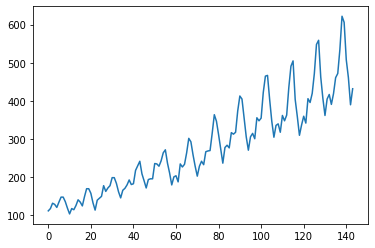

,time_idx,value,mes,group
0,0,112,1,a
1,1,118,2,a
2,2,132,3,a
3,3,129,4,a
4,4,121,5,a
...,...,...,...,...
139,139,606,8,a
140,140,508,9,a
141,141,461,10,a
142,142,390,11,a


In [116]:
# Reading and Transformation
df = pd.read_csv("AirPassengers.csv")
df = df.reset_index()
df = df.rename(columns={"index":"time_idx", "Month":"month", "#Passengers":"value"})
df['month'] = pd.to_datetime(df['month'])
df["mes"] = df["month"].dt.month.astype(str)

df["value"].plot()
plt.show()

df = df.drop(columns=["month"])
df["group"] = "a"
display(df)


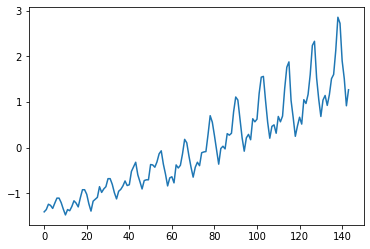

NAN:  0


In [117]:
# Normalization
scaler = StandardScaler()
df['value_norm'] = scaler.fit_transform(df[['value']])
df["value_norm"].plot()

#OneHot del Año
mes_oh = pd.get_dummies(df["mes"])
df_encoded = pd.concat([df, mes_oh], axis=1)

list_str = ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
for col in df_encoded:
    if col in list_str:
        df_encoded[col] = df_encoded[col].astype(str)

plt.show()
print("NAN: ", df["value_norm"].isna().sum())

In [139]:
max_prediction_length = 24
max_encoder_length = 110
training_cutoff = df_encoded["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_encoded[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value_norm",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_encoded, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [140]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1, 
    hidden_continuous_size=8, 
    loss=QuantileLoss(),
    optimizer="Ranger"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 8.2k


Finding best initial lr: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]
Learning rate set to 0.20892961308540398
Restoring states from the checkpoint path at d:\DataScience\TFT_Pytorch_Forecasting\.lr_find_22647eae-7f34-4f8e-bb89-31d65d301abb.ckpt
Restored all states from the checkpoint at d:\DataScience\TFT_Pytorch_Forecasting\.lr_find_22647eae-7f34-4f8e-bb89-31d65d301abb.ckpt


suggested learning rate: 0.20892961308540398


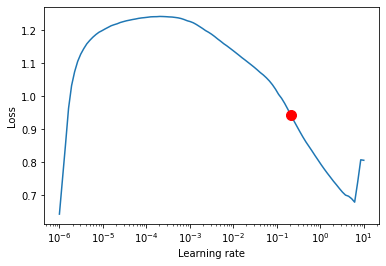

In [132]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [214]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=24, 
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=16,
    attention_head_size=8,
    dropout=0.2,
    hidden_continuous_size=8,
    loss=MAE(),
    log_interval=10, 
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.3k


In [215]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 24    
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s, v_num=22, train_loss_step=0.220, val_loss=0.304, train_loss_epoch=0.220]


In [216]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

IndexError: index 1 is out of bounds for dimension 0 with size 1

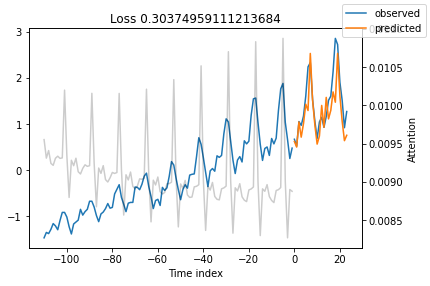

In [217]:
for idx in range(20):  # plot 10 examples
    tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)